In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np

In [2]:
from itertools import product

In [3]:
import tools

In [4]:
data = pd.read_json("data/flink/pr-flat_20220602-13h35m41s_apache_flink_master_prs-brief.txt", lines=True)

In [5]:
tools.initialize_datetime(data)

In [6]:
data['firstReview'] = tools.add_first_review_column(data)
data['timeToFirstReview'] = tools.add_time_to_first_review_column(data)
data['lifetime'] = tools.add_lifetime_column(data)

                          timeToFirstReviewInHours  lifetimeInHours
timeToFirstReviewInHours                  1.000000         0.249966
lifetimeInHours                           0.249966         1.000000


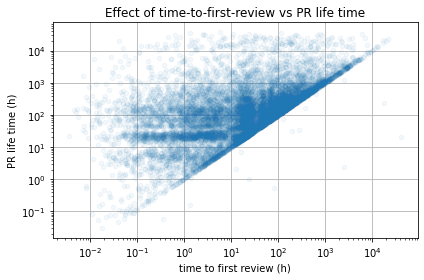

In [7]:
def plot_time_to_first_review_vs_lifetime(dataset: pd.DataFrame, alpha=0.05):
    subset = dataset.loc[~dataset['lifetime'].isna() & ~dataset['timeToFirstReview'].isna()].copy()
    f, ax = plt.subplots()
    subset['lifetimeInHours'] = subset['lifetime'].dt.total_seconds()/ (60*60)
    subset['timeToFirstReviewInHours'] = subset['timeToFirstReview'].dt.total_seconds()/ (60*60)
    subset.plot.scatter(x='timeToFirstReviewInHours', y='lifetimeInHours', alpha=alpha, ax=ax)
    ax.set(xlabel='time to first review (h)', ylabel='PR life time (h)')
    ax.grid()
    ax.loglog()
    ax.set_axisbelow(True)
    plt.title('Effect of time-to-first-review vs PR life time')
    print(subset[['timeToFirstReviewInHours', 'lifetimeInHours']].corr())
    return f, ax
    
f, ax = plot_time_to_first_review_vs_lifetime(data)
tools.savefig(f, 'prs_time_to_first_review_vs_life_time')

In [8]:
def author_pr_count_column(dataset: pd.DataFrame):
    dataset['_count'] = 1
    result = dataset.sort_values('createdAt').groupby('authorLogin')['_count'].cumsum().sort_index()
    del dataset['_count']
    return result

data['authorPrCount'] = author_pr_count_column(data)

In [9]:
def author_time_till_next_pr_column(dataset: pd.DataFrame):
    return dataset.sort_values('createdAt').groupby('authorLogin')['createdAt'].diff(-1).sort_index() * -1


data['authorTimeTillNextPr'] = author_time_till_next_pr_column(data)

In [10]:
data['authorTimeTillNextPr'].dropna().mean()

Timedelta('18 days 20:55:03.272881973')

                             authorTimeTillNextPrInHours  lifetimeInHours
authorTimeTillNextPrInHours                     1.000000         0.113901
lifetimeInHours                                 0.113901         1.000000
(1309, 24)


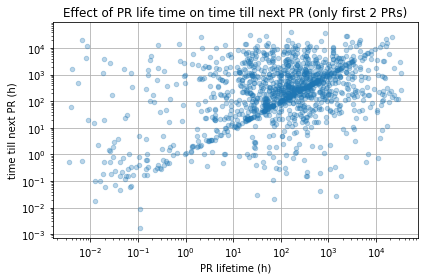

In [11]:
def plot_lifetime_vs_time_till_next_pr_for_early_contributors(dataset: pd.DataFrame, alpha=0.3, n=2):
    condition = (dataset['authorPrCount'] <= n) & (~dataset['authorTimeTillNextPr'].isna()) & (~dataset['lifetime'].isna())
    subset = dataset.loc[condition].copy()
    f, ax = plt.subplots()
    subset['authorTimeTillNextPrInHours'] = subset['authorTimeTillNextPr'].dt.total_seconds()/ (60*60)
    subset['lifetimeInHours'] = subset['lifetime'].dt.total_seconds()/ (60*60)
    subset.plot.scatter(x='lifetimeInHours', y='authorTimeTillNextPrInHours', alpha=alpha, ax=ax)
    ax.set(xlabel='PR lifetime (h)', ylabel='time till next PR (h)')
    ax.grid()
    ax.loglog()
    ax.set_axisbelow(True)
    print(subset[['authorTimeTillNextPrInHours', 'lifetimeInHours']].corr())
    print(subset.shape)
    plt.title(f'Effect of PR life time on time till next PR (only first {n} PRs)')
    return f, ax

f, ax = plot_lifetime_vs_time_till_next_pr_for_early_contributors(data)
tools.savefig(f, 'prs_lifetime_vs_time_till_next_pr')

In [12]:
data.loc[data['authorPrCount'] <= 5 & ~data['authorTimeTillNextPr'].isna() & ~data['lifetime'].isna()].shape

(794, 22)

In [13]:
data.loc[(data['authorLogin'] == 'metaswirl') & (data['authorPrCount'] <= 5)]

,title,state,number,createdAt,mergedAt,closedAt,labels,authorLogin,firstCommentCreatedAt,firstCommentPublishedAt,...,firstReviewThreadPublishedAt,firstReviewThreadAuthorLogin,firstReviewCreatedAt,firstReviewPublishedAt,firstReviewAuthorLogin,firstReview,timeToFirstReview,lifetime,authorPrCount,authorTimeTillNextPr
16637,[FLINK-25277] add shutdown hook to stop TaskEx...,CLOSED,18169,2021-12-21 16:29:20+00:00,NaT,2022-01-22 08:47:25+00:00,[component=Runtime/Coordination],metaswirl,2021-12-21 16:34:42+00:00,2021-12-21 16:34:42+00:00,...,2022-01-14 12:01:44+00:00,dmvk,2022-01-13 08:40:50+00:00,2022-01-13 08:40:50+00:00,tillrohrmann,2022-01-12 12:07:11+00:00,21 days 19:37:51,31 days 16:18:05,1,41 days 17:24:52
17003,[FLINK-25564][flink-tests] leave cleanup to rule,MERGED,18579,2022-02-01 09:54:12+00:00,2022-02-02 08:21:38+00:00,2022-02-02 08:21:38+00:00,[component=Runtime/Coordination],metaswirl,2022-02-01 09:58:37+00:00,2022-02-01 09:58:37+00:00,...,NaT,None,NaT,NaT,None,NaT,NaT,0 days 22:27:26,2,8 days 05:58:15
17094,[FLINK-21439][runtime] Exception history adapt...,MERGED,18689,2022-02-09 15:52:27+00:00,2022-02-17 21:41:47+00:00,2022-02-17 21:41:47+00:00,[component=Runtime/Coordination],metaswirl,2022-02-09 15:56:48+00:00,2022-02-09 15:56:48+00:00,...,2022-02-09 15:56:45+00:00,metaswirl,2022-02-09 15:56:45+00:00,2022-02-09 15:56:45+00:00,metaswirl,2022-02-09 15:56:45+00:00,0 days 00:04:18,8 days 05:49:20,3,19 days 01:13:35
17316,[FLINK-24474] set default for taskmanager.host,MERGED,18932,2022-02-28 17:06:02+00:00,2022-03-03 12:08:00+00:00,2022-03-03 12:08:00+00:00,[component=Runtime/Configuration],metaswirl,2022-02-28 17:16:34+00:00,2022-02-28 17:16:34+00:00,...,NaT,None,2022-03-01 12:46:47+00:00,2022-03-01 12:46:47+00:00,autophagy,2022-03-01 12:46:47+00:00,0 days 19:40:45,2 days 19:01:58,4,0 days 21:56:12
17326,[FLINK-22255][documentation] add note to docum...,MERGED,18948,2022-03-01 15:02:14+00:00,2022-03-02 14:04:55+00:00,2022-03-02 14:04:56+00:00,[component=Runtime/Coordination],metaswirl,2022-03-01 15:30:13+00:00,2022-03-01 15:30:13+00:00,...,NaT,None,2022-03-01 15:06:11+00:00,2022-03-01 15:06:11+00:00,dmvk,2022-03-01 15:06:11+00:00,0 days 00:03:57,0 days 23:02:42,5,0 days 00:14:44


                             timeToFirstReviewInHours  \
timeToFirstReviewInHours                     1.000000   
authorTimeTillNextPrInHours                  0.028187   

                             authorTimeTillNextPrInHours  
timeToFirstReviewInHours                        0.028187  
authorTimeTillNextPrInHours                     1.000000  


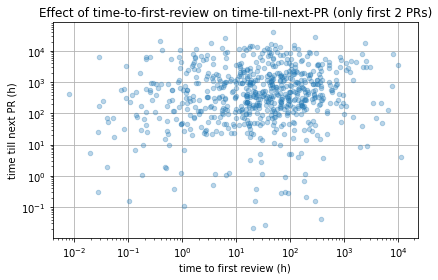

In [14]:
def plot_time_to_first_pr_vs_time_till_next_pr_for_early_contributors(dataset: pd.DataFrame, alpha=0.3, n=2):
    condition = (dataset['authorPrCount'] <= n) & (~dataset['authorTimeTillNextPr'].isna()) & (~dataset['timeToFirstReview'].isna())    
    subset = dataset.loc[condition].copy()
    f, ax = plt.subplots()
    subset['authorTimeTillNextPrInHours'] = subset['authorTimeTillNextPr'].dt.total_seconds()/ (60*60)
    subset['timeToFirstReviewInHours'] = subset['timeToFirstReview'].dt.total_seconds()/ (60*60)
    subset.plot.scatter(x='timeToFirstReviewInHours', y='authorTimeTillNextPrInHours', alpha=alpha, ax=ax)
    ax.set(xlabel='time to first review (h)', ylabel='time till next PR (h)')
    ax.grid()
    ax.loglog()
    ax.set_axisbelow(True)
    print(subset[['timeToFirstReviewInHours', 'authorTimeTillNextPrInHours']].corr())
    plt.title(f'Effect of time-to-first-review on time-till-next-PR (only first {n} PRs)')
    return f, ax

f, ax = plot_time_to_first_pr_vs_time_till_next_pr_for_early_contributors(data)
tools.savefig(f, 'prs_time_to_first_review_vs_time_till_next_pr')

In [15]:
author_pr_count = data.groupby('authorLogin')['title'].count().reset_index().rename(columns={'title': 'count'})
authors_with_more_than_one_pr = author_pr_count.loc[author_pr_count['count'] > 1, 'authorLogin']
authors_with_one_pr = author_pr_count.loc[author_pr_count['count'] == 1, 'authorLogin']

In [16]:
first_pr_author_with_one_pr = data.loc[data['authorLogin'].isin(authors_with_one_pr)].copy()
first_pr_author_with_more_than_one_pr = data.loc[(data['authorLogin'].isin(authors_with_more_than_one_pr)) & (data['authorPrCount'] == 1)].copy()

In [17]:
first_pr_author_with_one_pr['lifetimeInHours'] = first_pr_author_with_one_pr['lifetime'].dt.total_seconds() / (60 * 60)
first_pr_author_with_one_pr['timeToFirstReviewInHours'] = first_pr_author_with_one_pr['timeToFirstReview'].dt.total_seconds() / (60 * 60)
first_pr_author_with_more_than_one_pr['lifetimeInHours'] = first_pr_author_with_more_than_one_pr['lifetime'].dt.total_seconds() / (60 * 60)
first_pr_author_with_more_than_one_pr['timeToFirstReviewInHours'] = first_pr_author_with_more_than_one_pr['timeToFirstReview'].dt.total_seconds() / (60 * 60)


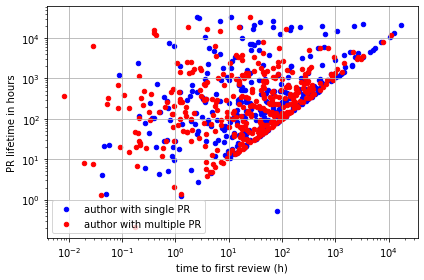

In [18]:
f, ax = plt.subplots()
first_pr_author_with_one_pr.plot.scatter(x='timeToFirstReviewInHours', y='lifetimeInHours', ax=ax, color='blue', label='author with single PR')
first_pr_author_with_more_than_one_pr.plot.scatter(x='timeToFirstReviewInHours', y='lifetimeInHours', ax=ax, color='red', label='author with multiple PR')
ax.loglog()
ax.grid()
ax.set(xlabel='time to first review (h)', ylabel='PR lifetime in hours')
tools.savefig(f, 'prs_authors_with_single_and_multiple_prs')

In [19]:
pd.concat([first_pr_author_with_one_pr[['lifetime', 'timeToFirstReview']].std(),
          first_pr_author_with_more_than_one_pr[['lifetime', 'timeToFirstReview']].std()], axis=1)\
.rename(columns={0: 'singlePRauthors', 1: 'multiplePRauthors'})

,singlePRauthors,multiplePRauthors
lifetime,207 days 04:01:31.579456826,133 days 02:49:35.745573766
timeToFirstReview,59 days 20:59:53.058263947,32 days 13:36:31.475402189


In [20]:
first_pr_author_with_more_than_one_pr[['lifetime', 'timeToFirstReview']].mean()

lifetime            43 days 17:55:11.409448819
timeToFirstReview    7 days 15:07:49.145408163
dtype: timedelta64[ns]

In [21]:
first_pr_author_with_one_pr

,title,state,number,createdAt,mergedAt,closedAt,labels,authorLogin,firstCommentCreatedAt,firstCommentPublishedAt,...,firstReviewCreatedAt,firstReviewPublishedAt,firstReviewAuthorLogin,firstReview,timeToFirstReview,lifetime,authorPrCount,authorTimeTillNextPr,lifetimeInHours,timeToFirstReviewInHours
36,hadoopcompatibility: Implementations of basic ...,CLOSED,37,2014-06-24 13:01:40+00:00,NaT,2014-11-20 11:51:45+00:00,[],atsikiridis,2014-06-25 07:02:17+00:00,2014-06-25 07:02:17+00:00,...,NaT,NaT,None,2014-07-08 12:15:15+00:00,13 days 23:13:35,148 days 22:50:05,1,NaT,3574.834722,335.226389
41,New operator map partition function,CLOSED,42,2014-06-25 13:45:44+00:00,NaT,2014-08-15 11:09:24+00:00,[],kfleischmann,2014-06-25 13:53:30+00:00,2014-06-25 13:53:30+00:00,...,NaT,NaT,None,2014-06-25 13:51:01+00:00,0 days 00:05:17,50 days 21:23:40,1,NaT,1221.394444,0.088056
48,Mention that Oracle JDK 6 library will fail to...,CLOSED,49,2014-06-30 08:48:30+00:00,NaT,2014-06-30 08:52:47+00:00,[],colorant,2014-06-30 08:52:56+00:00,2014-06-30 08:52:56+00:00,...,NaT,NaT,None,NaT,NaT,0 days 00:04:17,1,NaT,0.071389,NaN
95,make CI build faster,CLOSED,97,2014-08-16 16:51:58+00:00,NaT,2014-08-18 17:27:01+00:00,[],PeterDaveHello,2014-08-16 17:01:35+00:00,2014-08-16 17:01:35+00:00,...,NaT,NaT,None,NaT,NaT,2 days 00:35:03,1,NaT,48.584167,NaN
182,[FLINK-1008] Fix createProgramPlan() throws ex...,CLOSED,184,2014-11-05 21:42:36+00:00,NaT,2014-11-17 13:45:05+00:00,[component=<none>],knub,2014-11-07 15:22:00+00:00,2014-11-07 15:22:00+00:00,...,NaT,NaT,None,NaT,NaT,11 days 16:02:29,1,NaT,280.041389,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18048,[FLINK-27800][streaming] Fix addInEdge but che...,OPEN,19824,2022-05-26 11:07:56+00:00,NaT,NaT,[component=API/Core],leechor,2022-05-26 11:11:23+00:00,2022-05-26 11:11:23+00:00,...,NaT,NaT,None,NaT,NaT,NaT,1,NaT,NaN,NaN
18053,[FLINK-27807][Connectors/JDBC] The improvement...,OPEN,19829,2022-05-27 03:57:58+00:00,NaT,NaT,[component=Connectors/JDBC],shmilygkd,2022-05-27 03:59:52+00:00,2022-05-27 03:59:52+00:00,...,NaT,NaT,None,NaT,NaT,NaT,1,NaT,NaN,NaN
18068,[FLINK-27805][Connectors/ORC] bump orc version...,OPEN,19844,2022-05-30 08:18:12+00:00,NaT,NaT,[component=Formats],liujiawinds,2022-05-30 08:23:41+00:00,2022-05-30 08:23:41+00:00,...,NaT,NaT,None,NaT,NaT,NaT,1,NaT,NaN,NaN
18071,[FLINK-27683][table-planner] Fix SQL hints can...,OPEN,19847,2022-05-31 02:46:04+00:00,NaT,NaT,[component=TableSQL/Planner],xuanyu66,2022-05-31 02:51:06+00:00,2022-05-31 02:51:06+00:00,...,2022-05-31 06:04:30+00:00,2022-05-31 06:04:30+00:00,fsk119,2022-05-31 06:04:30+00:00,0 days 03:18:26,NaT,1,NaT,NaN,3.307222
